<a href="https://colab.research.google.com/github/SERVIR/RX_fires/blob/main/Burn_Severity_Training_data_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Testign with Flame dataset: https://ieee-dataport.org/open-access/flame-dataset-aerial-imagery-pile-burn-detection-using-drones-uavs

Alireza Shamsoshoara, Fatemeh Afghah, Abolfazl Razi, Liming Zheng, Peter Fulé, Erik Blasch, "The FLAME dataset: Aerial Imagery Pile burn detection using drones (UAVs)", IEEE Dataport, November 19, 2020, doi:10.21227/qad6-r683

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pwd

/content


In [5]:
data_dir = '/content/drive/Shareddrives/SCO-Shared/Science Resources/Thematic Service Areas/Ecosystem&CarbonManagement/Rx_Fire/Training.zip'

In [8]:
import zipfile
import os

# ✅ Your zip file path from Google Drive
data_dir = '/content/drive/Shareddrives/SCO-Shared/Science Resources/Thematic Service Areas/Ecosystem&CarbonManagement/Rx_Fire/Training.zip'

# ✅ Destination to extract inside Colab
extract_to = '/content/train_unzip'

# 🔄 Unzip the file if not already extracted
if not os.path.exists(extract_to):
    os.makedirs(extract_to, exist_ok=True)
    with zipfile.ZipFile(data_dir, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"✅ Extracted to: {extract_to}")
else:
    print(f"⚠️ Already extracted at: {extract_to}")


✅ Extracted to: /content/train_unzip


In [ ]:
# !wget -O flame_dataset.zip "https://ieee-dataport.org/sites/default/files/FLAME-Dataset-v1.zip"
# !unzip flame_dataset.zip -d flame_data


#/content/train_unzip/Training
  ├── Fire/

  │     ├── img_001.jpg

  │     ├── img_002.jpg

  ├── No_Fire/


  │     ├── img_001.jpg

  │     ├── img_002.jpg



🔁 Processing Fire images...


100%|██████████| 25018/25018 [00:35<00:00, 699.65it/s]



🔥 Severity: low


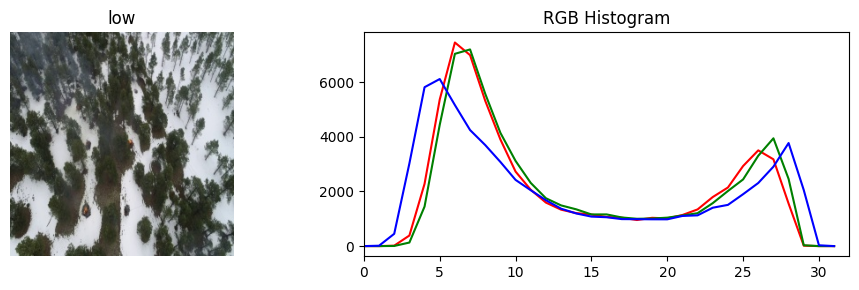

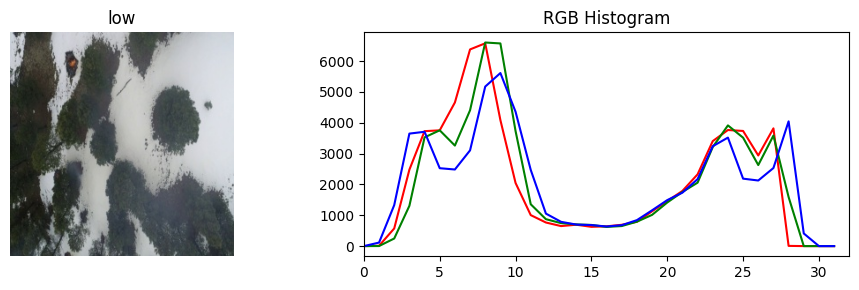

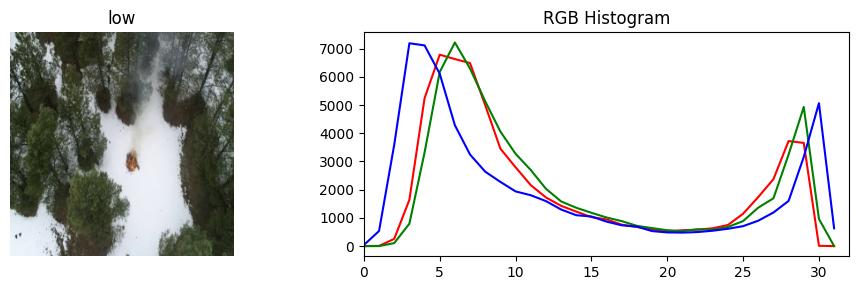


🔥 Severity: medium


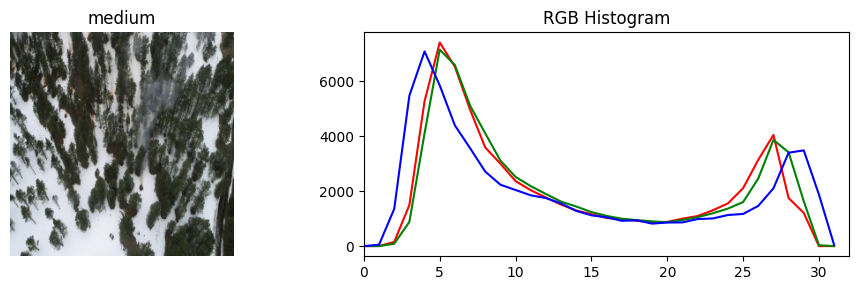

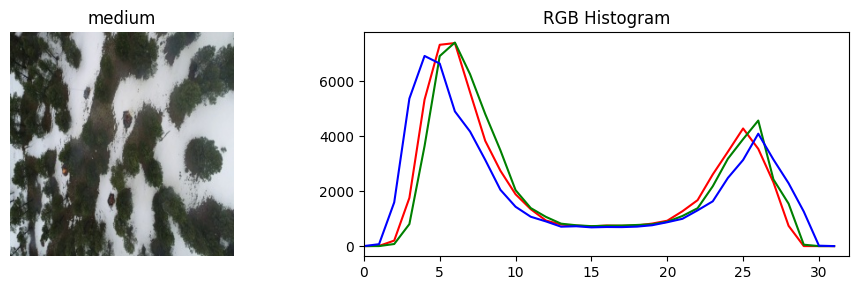

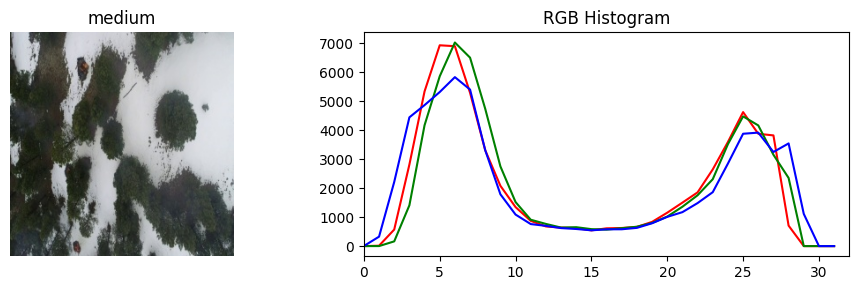


🔥 Severity: high


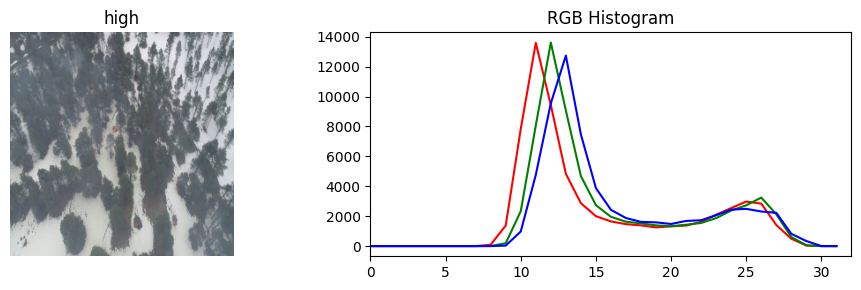

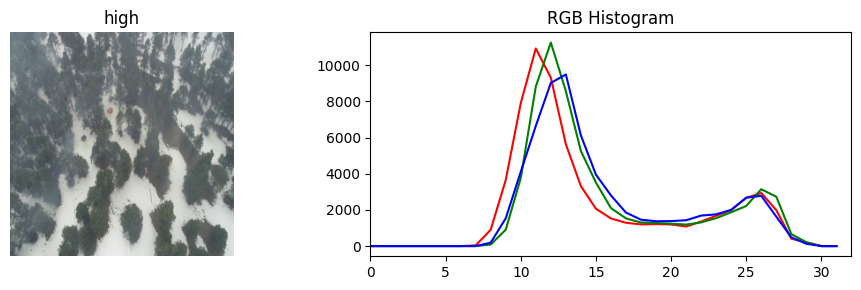

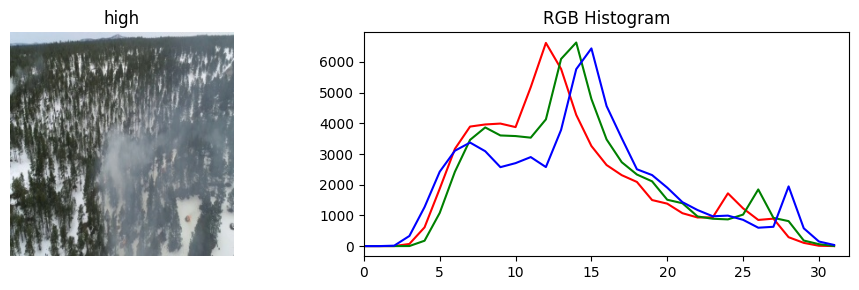


🔥 Severity: extreme


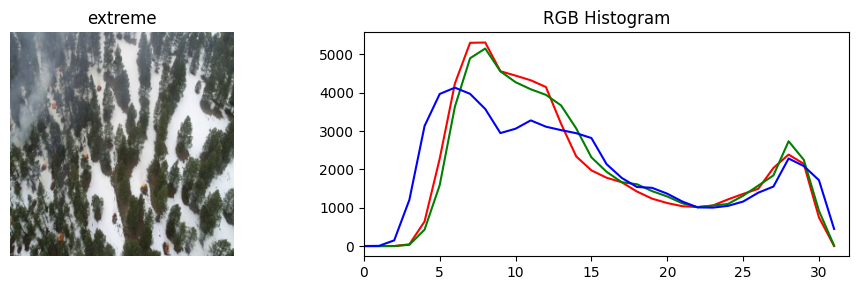

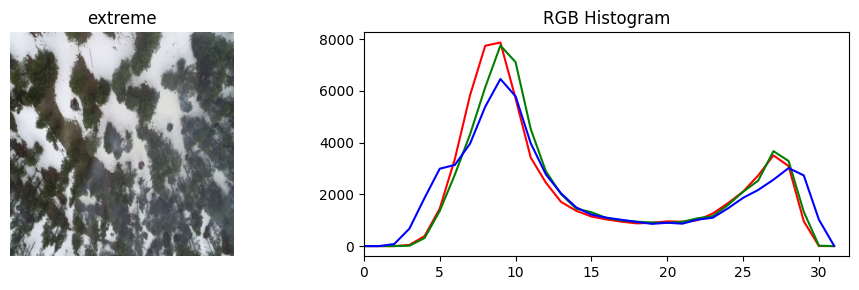

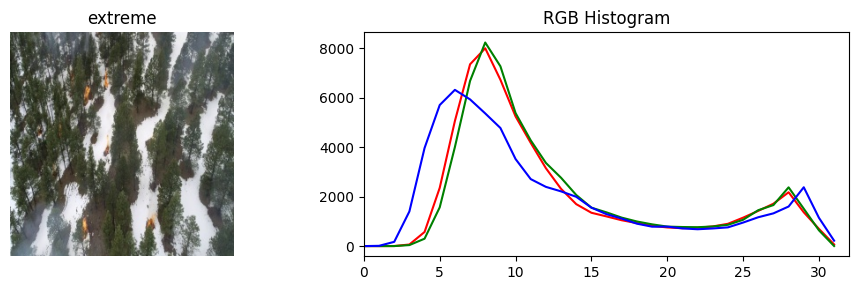

🔥 Cluster distribution (unsorted):
extreme: 9716 images
high: 3778 images
low: 5488 images
medium: 6036 images

🔥 Severity: low


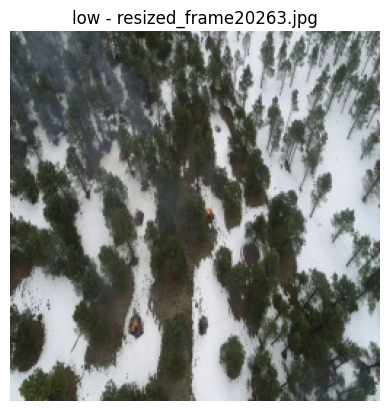

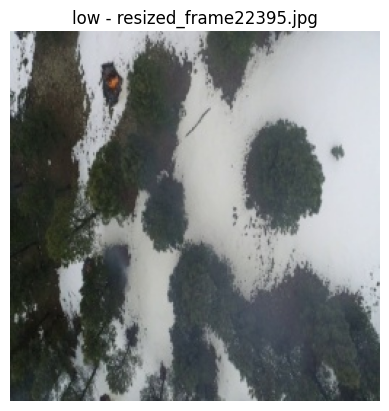

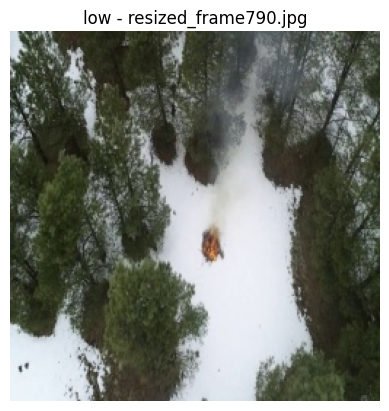


🔥 Severity: medium


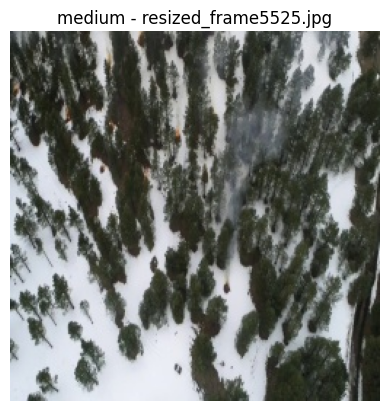

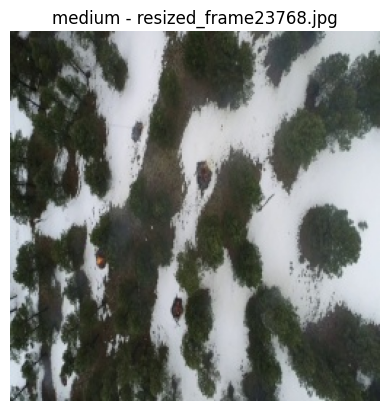

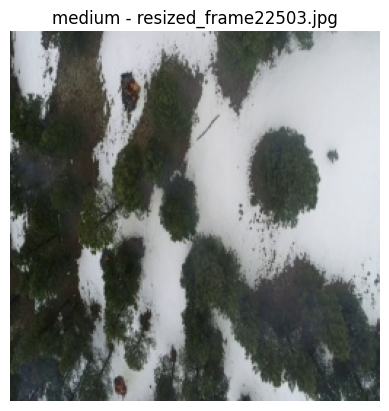


🔥 Severity: high


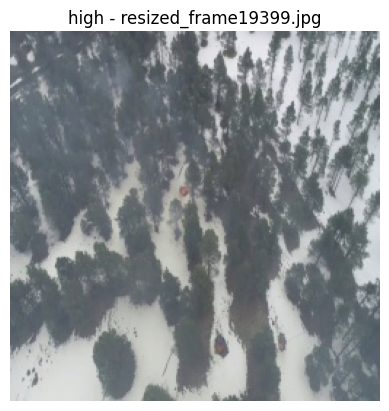

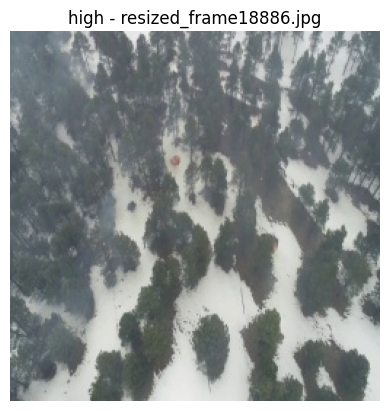

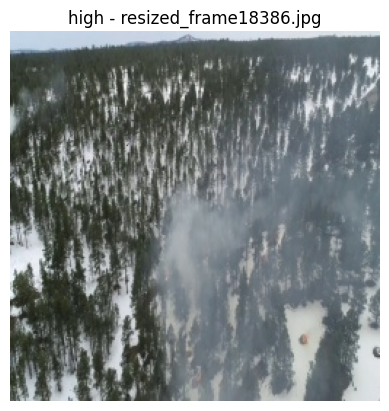


🔥 Severity: extreme


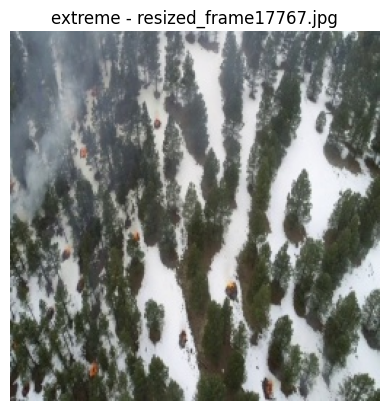

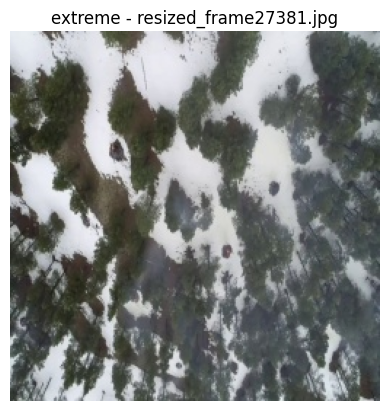

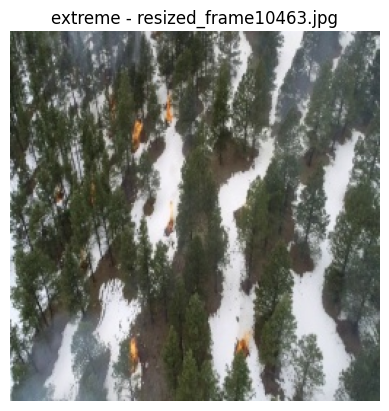

image_path  cluster_id burn_severity
0  /content/train_unzip/Training/Fire/resized_fra...           3       extreme
1  /content/train_unzip/Training/Fire/resized_fra...           2          high
2  /content/train_unzip/Training/Fire/resized_fra...           3       extreme
3  /content/train_unzip/Training/Fire/resized_fra...           0           low
4  /content/train_unzip/Training/Fire/resized_fra...           1        medium

In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm
import glob

# Step 1: Define folders
fire_dir = '/content/train_unzip/Training/Fire'
no_fire_dir = '/content/train_unzip/Training/No_Fire'

# Step 2: Helper to compute RGB histogram (normalized, 32 bins per channel)
def compute_rgb_histogram(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))  # Resize to standardize input
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hist = np.concatenate([
        cv2.calcHist([img], [i], None, [32], [0, 256]).flatten()
        for i in range(3)
    ])
    return hist / hist.sum()  # Normalize histogram

# Step 3: Gather Fire histograms
fire_images = glob.glob(fire_dir + '/*.jpg')
fire_hists = []
fire_paths = []

print("🔁 Processing Fire images...")
for path in tqdm(fire_images):
    fire_paths.append(path)
    fire_hists.append(compute_rgb_histogram(path))

fire_hists = np.array(fire_hists)

# Step 4: KMeans clustering into burn severity levels
k = 4  # Number of severity levels: low, medium, high, extreme
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(fire_hists)

# Optional: map numeric labels to readable classes
severity_map = {
    0: 'low',
    1: 'medium',
    2: 'high',
    3: 'extreme'
}

###########

def show_example_images_with_histograms(n_per_cluster=3):
    for cluster_id in range(k):
        indices = [i for i, lbl in enumerate(labels) if lbl == cluster_id]
        print(f"\n🔥 Severity: {severity_map[cluster_id]}")

        for i in indices[:n_per_cluster]:
            img_path = fire_paths[i]
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Compute histogram
            chans = cv2.split(img_rgb)
            colors = ("r", "g", "b")
            plt.figure(figsize=(10, 3))

            # Show image
            plt.subplot(1, 2, 1)
            plt.imshow(img_rgb)
            plt.title(f"{severity_map[cluster_id]}")
            plt.axis('off')

            # Plot histogram
            plt.subplot(1, 2, 2)
            for chan, color in zip(chans, colors):
                hist = cv2.calcHist([chan], [0], None, [32], [0, 256])
                plt.plot(hist, color=color)
                plt.xlim([0, 32])
            plt.title("RGB Histogram")
            plt.tight_layout()
            plt.show()


show_example_images_with_histograms(n_per_cluster=3)



# Count and assign categories
from collections import Counter
counts = Counter(labels)
print("🔥 Cluster distribution (unsorted):")
for label, count in counts.items():
    print(f"{severity_map[label]}: {count} images")

# Step 5: Visualize example from each cluster
def show_example_images_per_cluster(n_per_cluster=3):
    for cluster_id in range(k):
        indices = [i for i, lbl in enumerate(labels) if lbl == cluster_id]
        print(f"\n🔥 Severity: {severity_map[cluster_id]}")
        for i in indices[:n_per_cluster]:
            img = cv2.imread(fire_paths[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(f"{severity_map[cluster_id]} - {os.path.basename(fire_paths[i])}")
            plt.axis('off')
            plt.show()

# Optional: visualize
show_example_images_per_cluster()

import pandas as pd

# Create the table with image paths and severity labels
df = pd.DataFrame({
    'image_path': fire_paths,
    'cluster_id': labels,
    'burn_severity': [severity_map[label] for label in labels]
})

# Preview the table
df.head()

# # Save to file (in Colab)
# csv_output_path = '/content/fire_image_burn_severity.csv'
# df.to_csv(csv_output_path, index=False)

# print(f"✅ CSV saved to: {csv_output_path}")


dev

In [ ]:
# # STEP 1: Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # STEP 2: Imports
# import os
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler

# # STEP 3: Paths
# pre_path = "/content/drive/MyDrive/fire_images/pre"
# post_path = "/content/drive/MyDrive/fire_images/post"

# # STEP 4: Function to compute RGB histograms
# def compute_histogram(image_path, bins=32):
#     img = cv2.imread(image_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     hist_r = cv2.calcHist([img], [0], None, [bins], [0, 256]).flatten()
#     hist_g = cv2.calcHist([img], [1], None, [bins], [0, 256]).flatten()
#     hist_b = cv2.calcHist([img], [2], None, [bins], [0, 256]).flatten()
#     hist = np.concatenate([hist_r, hist_g, hist_b])
#     hist = hist / hist.sum()  # Normalize
#     return hist

# # STEP 5: Collect features from image pairs
# features = []
# image_ids = []

# pre_files = sorted(os.listdir(pre_path))
# for fname in pre_files:
#     pre_img = os.path.join(pre_path, fname)
#     post_img = os.path.join(post_path, fname)

#     if not os.path.exists(post_img):
#         continue

#     hist_pre = compute_histogram(pre_img)
#     hist_post = compute_histogram(post_img)

#     diff_hist = hist_post - hist_pre  # Change feature
#     features.append(diff_hist)
#     image_ids.append(fname)

# features = np.array(features)
# print("Feature shape:", features.shape)


optional

In [ ]:
# # Standardize features
# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(features)

# # Use k-means to group into 3 clusters: low, medium, high
# kmeans = KMeans(n_clusters=3, random_state=42)
# labels = kmeans.fit_predict(features_scaled)

# # Map cluster labels to severity classes (you can manually inspect and reassign if needed)
# severity_map = {0: 'Low', 1: 'Medium', 2: 'High'}
# image_severity = {image_ids[i]: severity_map[labels[i]] for i in range(len(labels))}

# # Print results
# for img, label in image_severity.items():
#     print(f"{img}: {label}")


In [ ]:
# def plot_hist_diff(fname):
#     pre_img = os.path.join(pre_path, fname)
#     post_img = os.path.join(post_path, fname)

#     hist_pre = compute_histogram(pre_img)
#     hist_post = compute_histogram(post_img)

#     plt.figure(figsize=(10, 3))
#     plt.plot(hist_pre, label='Pre', alpha=0.7)
#     plt.plot(hist_post, label='Post', alpha=0.7)
#     plt.title(f"Histogram Comparison - {fname}")
#     plt.legend()
#     plt.show()

# # Example
# plot_hist_diff(image_ids[0])
